In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import getpass

user = getpass.getuser()

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
# change file name here for RCP8.5
ce = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/damages_ce.csv") 
mc = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/damages_nocons.csv")
ce = ce[["discrate","year","pulse","rcp","damages", "variable"]]
mc = mc[["discrate","year","pulse","rcp","damages", "variable"]]
ce = ce[(ce.rcp == "rcp45")]
mc = mc[(mc.rcp == "rcp45")]

In [14]:
damages = pd.merge(ce, mc, on= ['discrate', 'year', 'pulse', 'rcp'], how = 'inner')
damages['diff_damages'] = damages.damages_x - damages.damages_y
# damages

In [15]:
damages.groupby('discrate')['diff_damages'].describe()

,count,mean,std,min,25%,50%,75%,max
discrate,,,,,,,,
1.0,286.0,0.000522,0.000219,0.0,3.521505e-04,0.000486,0.000729,0.000882
2.0,286.0,0.000131,0.000077,0.0,7.959165e-05,0.000107,0.000133,0.000305
2.5,286.0,0.000083,0.000080,0.0,2.977339e-05,0.000052,0.000092,0.000284
3.0,286.0,0.000059,0.000075,0.0,1.026917e-05,0.000027,0.000063,0.000266
5.0,286.0,0.000026,0.000052,0.0,1.529524e-07,0.000002,0.000015,0.000221


In [6]:
# run the following two cells only if the min value in above summary stats is negative
damages[(damages['diff_damages'] < 0)].groupby('discrate')['diff_damages'].describe()

,count,mean,std,min,25%,50%,75%,max
discrate,,,,,,,,
1.0,56.0,-6.283304e-05,3.228441e-05,-0.000114,-9.038793e-05,-5.975060e-05,-4.187108e-05,-2.550354e-07
2.0,56.0,-1.835386e-05,9.469735e-06,-0.000033,-2.605399e-05,-1.907649e-05,-1.214218e-05,-5.818094e-08
2.5,56.0,-1.002275e-05,5.249269e-06,-0.000018,-1.394781e-05,-1.107462e-05,-6.119773e-06,-2.794002e-08
3.0,56.0,-5.510275e-06,2.953055e-06,-0.000010,-7.602182e-06,-6.174482e-06,-3.069361e-06,-1.346551e-08
5.0,56.0,-5.371141e-07,3.344408e-07,-0.000001,-7.700744e-07,-5.567222e-07,-1.926001e-07,-7.523357e-10


In [7]:
# generating a list of years where diff damages is negative
years_low = damages.loc[damages.diff_damages < 0].year.unique()
years_low

array([2110., 2115., 2116., 2117., 2118., 2119., 2120., 2121., 2122.,
       2123., 2124., 2125., 2126., 2127., 2128., 2129., 2130., 2131.,
       2132., 2133., 2134., 2135., 2136., 2137., 2138., 2139., 2140.,
       2141., 2142., 2143., 2144., 2145., 2146., 2147., 2148., 2149.,
       2150., 2151., 2152., 2153., 2154., 2155., 2156., 2157., 2158.,
       2159., 2160., 2161., 2162., 2163., 2164., 2165., 2170., 2171.,
       2172., 2173.])

In [16]:
# reading the coeffs in ce and mc to obtain damage functions

ce_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/ce_betas_SSP3.csv")
ce_coeffs = ce_coeffs[["year", "cons","beta1","beta2"]]

mc_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/nocons_betas_SSP3.csv")
mc_coeffs = mc_coeffs[["year", "cons","beta1","beta2"]]

In [17]:
# ANALYSIS FOR RCP4.5

coeffs = pd.merge(ce_coeffs, mc_coeffs, on= ['year'], how = 'inner') 
# coeffs = coeffs[coeffs['year'].isin(years_low)] # uncomment if comparison wanted only for years where ce damages < regular damages

fair = pd.read_csv("/mnt/CIL_labor/6_ce/rcp45_anomalies.csv")

df = pd.merge(coeffs, fair, on= ['year'], how = 'inner')

# generate CE variables: damages due to pulse and level at rcp anomaly 
df['pulse_df_ce'] = (df.cons_x + df.fair_temperatures_anomaly_pulse * df.beta1_x + df.fair_temperatures_anomaly_pulse**2 * df.beta2_x)
df['level_ce'] = (df.cons_x + df.fair_temperatures_anomaly_rcp * df.beta1_x + df.fair_temperatures_anomaly_rcp**2 * df.beta2_x)
df['ce_damages'] = df.pulse_df_ce - df.level_ce

# generate non-CE variables: damages due to pulse and level at rcp anomaly 
df['pulse_df_mc'] = (df.cons_y + df.fair_temperatures_anomaly_pulse * df.beta1_y + df.fair_temperatures_anomaly_pulse**2 * df.beta2_y)
df['level_reg'] = (df.cons_y + df.fair_temperatures_anomaly_rcp * df.beta1_y + df.fair_temperatures_anomaly_rcp**2 * df.beta2_y)
df['reg_damages'] = df.pulse_df_mc - df.level_reg

# diff between CE and non-CE damages
df['diff'] = df.ce_damages - df.reg_damages

# slope = beta1 + 2*beta2*fair_anomaly for each case for rcp anomaly
df['slope_ce'] = (df.beta1_x + 2 * df.fair_temperatures_anomaly_rcp * df.beta2_x)
df['slope_reg'] = (df.beta1_y + 2 * df.fair_temperatures_anomaly_rcp * df.beta2_y)

# final df
df[['year', 'ce_damages', 'reg_damages', 'fair_temperatures_anomaly_rcp', 'diff', 'level_ce', 'level_reg', 'slope_ce', 'slope_reg']]#.to_csv('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/rcp45_df.csv')

# dff[dff['year'].isin(years_low)]


,year,ce_damages,reg_damages,fair_temperatures_anomaly_rcp,diff,level_ce,level_reg,slope_ce,slope_reg
0,2015,0.000000,0.000000,0.157163,0.000000e+00,0.006136,0.005908,0.023408,0.022431
1,2016,0.000000,0.000000,0.166119,0.000000e+00,0.008339,0.008108,0.023088,0.022111
2,2017,0.000000,0.000000,0.176350,0.000000e+00,0.007531,0.007294,0.015095,0.014136
3,2018,0.000000,0.000000,0.188346,0.000000e+00,0.008297,0.008058,0.012416,0.011458
4,2019,0.000000,0.000000,0.202157,0.000000e+00,0.008909,0.008661,0.010747,0.009808
5,2020,0.000011,0.000010,0.218159,5.550990e-07,0.011643,0.011379,0.017817,0.016890
6,2021,0.000033,0.000032,0.240173,8.892326e-07,0.013329,0.013048,0.033552,0.032648
7,2022,0.000049,0.000048,0.267228,1.079829e-06,0.020614,0.020306,0.039627,0.038750
8,2023,0.000071,0.000070,0.295880,1.196941e-06,0.025761,0.025429,0.051315,0.050455
9,2024,0.000096,0.000095,0.323962,1.252787e-06,0.032583,0.032223,0.064688,0.063848


In [18]:
len(df.loc[df.level_ce < df.level_reg].year.unique())
df.loc[df.level_ce < df.level_reg].year.unique()

array([2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090,
       2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101,
       2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112,
       2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123,
       2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134,
       2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145,
       2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156,
       2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167,
       2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178,
       2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189,
       2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200,
       2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211,
       2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222,
       2223, 2224, 2225, 2226, 2227, 2228, 2229, 22

In [19]:
# generating df of anomalies between -5 to 20 in 1101 steps for each year between 2015 to 2100
temp_range = np.linspace(0.25, 4.25, 17)
idx = product(range(2015,2301), temp_range) 
temps = np.stack([temp_range for _ in range(2015,2301)]).flatten() 
temps = pd.DataFrame(temps, index=[i for i,x in idx], columns=['temp'])
temps = temps.reset_index().rename(columns={"index":"year"})
# temps # checking things out

In [20]:
# certainty equivalence damage function
ce_df = pd.merge(ce_coeffs, temps, on= ['year'], how = 'inner') 
ce_df['ce_df_T'] = (ce_df.cons + ce_df.temp * ce_df.beta1 + ce_df.temp**2 * ce_df.beta2)
# ce_df # checking things out

# non-CE cloud labor mc damage function
mc_df = pd.merge(mc_coeffs, temps, on= ['year'], how = 'inner')
mc_df['mc_df_T'] = (mc_df.cons + mc_df.temp * mc_df.beta1 + mc_df.temp**2 * mc_df.beta2)
# mc_sm_df # checking things out

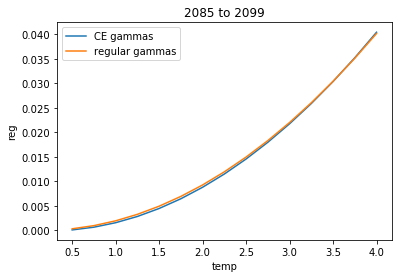

In [21]:
# rate of change of regular vs ce damages under RCP4.5

t = temps.loc[temps.year==2015]
t = t[t['temp'].between(0.48, 4.12)]
t['ce'] = -.0013502 * t.temp + .0028658 * t.temp**2
t['reg'] = -.0008155 * t.temp + .002716 * t.temp**2
t = t[['temp', 'ce', 'reg']]

# reg_values = pd.read_csv("/mnt/CIL_labor/6_ce/reg_values.csv")
# reg_values[reg_values['year'].between(2085,2099)].groupby('rcp')['temp'].describe()

sns.lineplot(data=t, x='temp', y='ce', label="CE gammas").set_title("2085 to 2099")
sns.lineplot(data=t, x='temp', y='reg', label="regular gammas")
plt.legend()
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/rate_of_change.pdf', format='pdf')


In [13]:
# overlaid grid plot of all years where ce_df_T < mc_df_T as per the SCC calculation

# comparison of smooth anomalies: CE, non-CE cloud, and non-CE mean 
df1 = pd.merge(ce_df, mc_df, on = ['year', 'temp'], how = 'outer')
df1 = df1[df1['year'].isin(years_low)]
# df1.to_csv('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/dfs_low_years.csv')

# generating years from 2020 to 2100 at every ten years
years = list(range(2020, 2301, 10))

# comparison of non-CE cloud smooth vs non-smooth anomalies
df2 = pd.merge(ce_df, mc_df, on = ['year', 'temp'], how = 'outer')
df2 = df2[df2['year'].isin(years)]



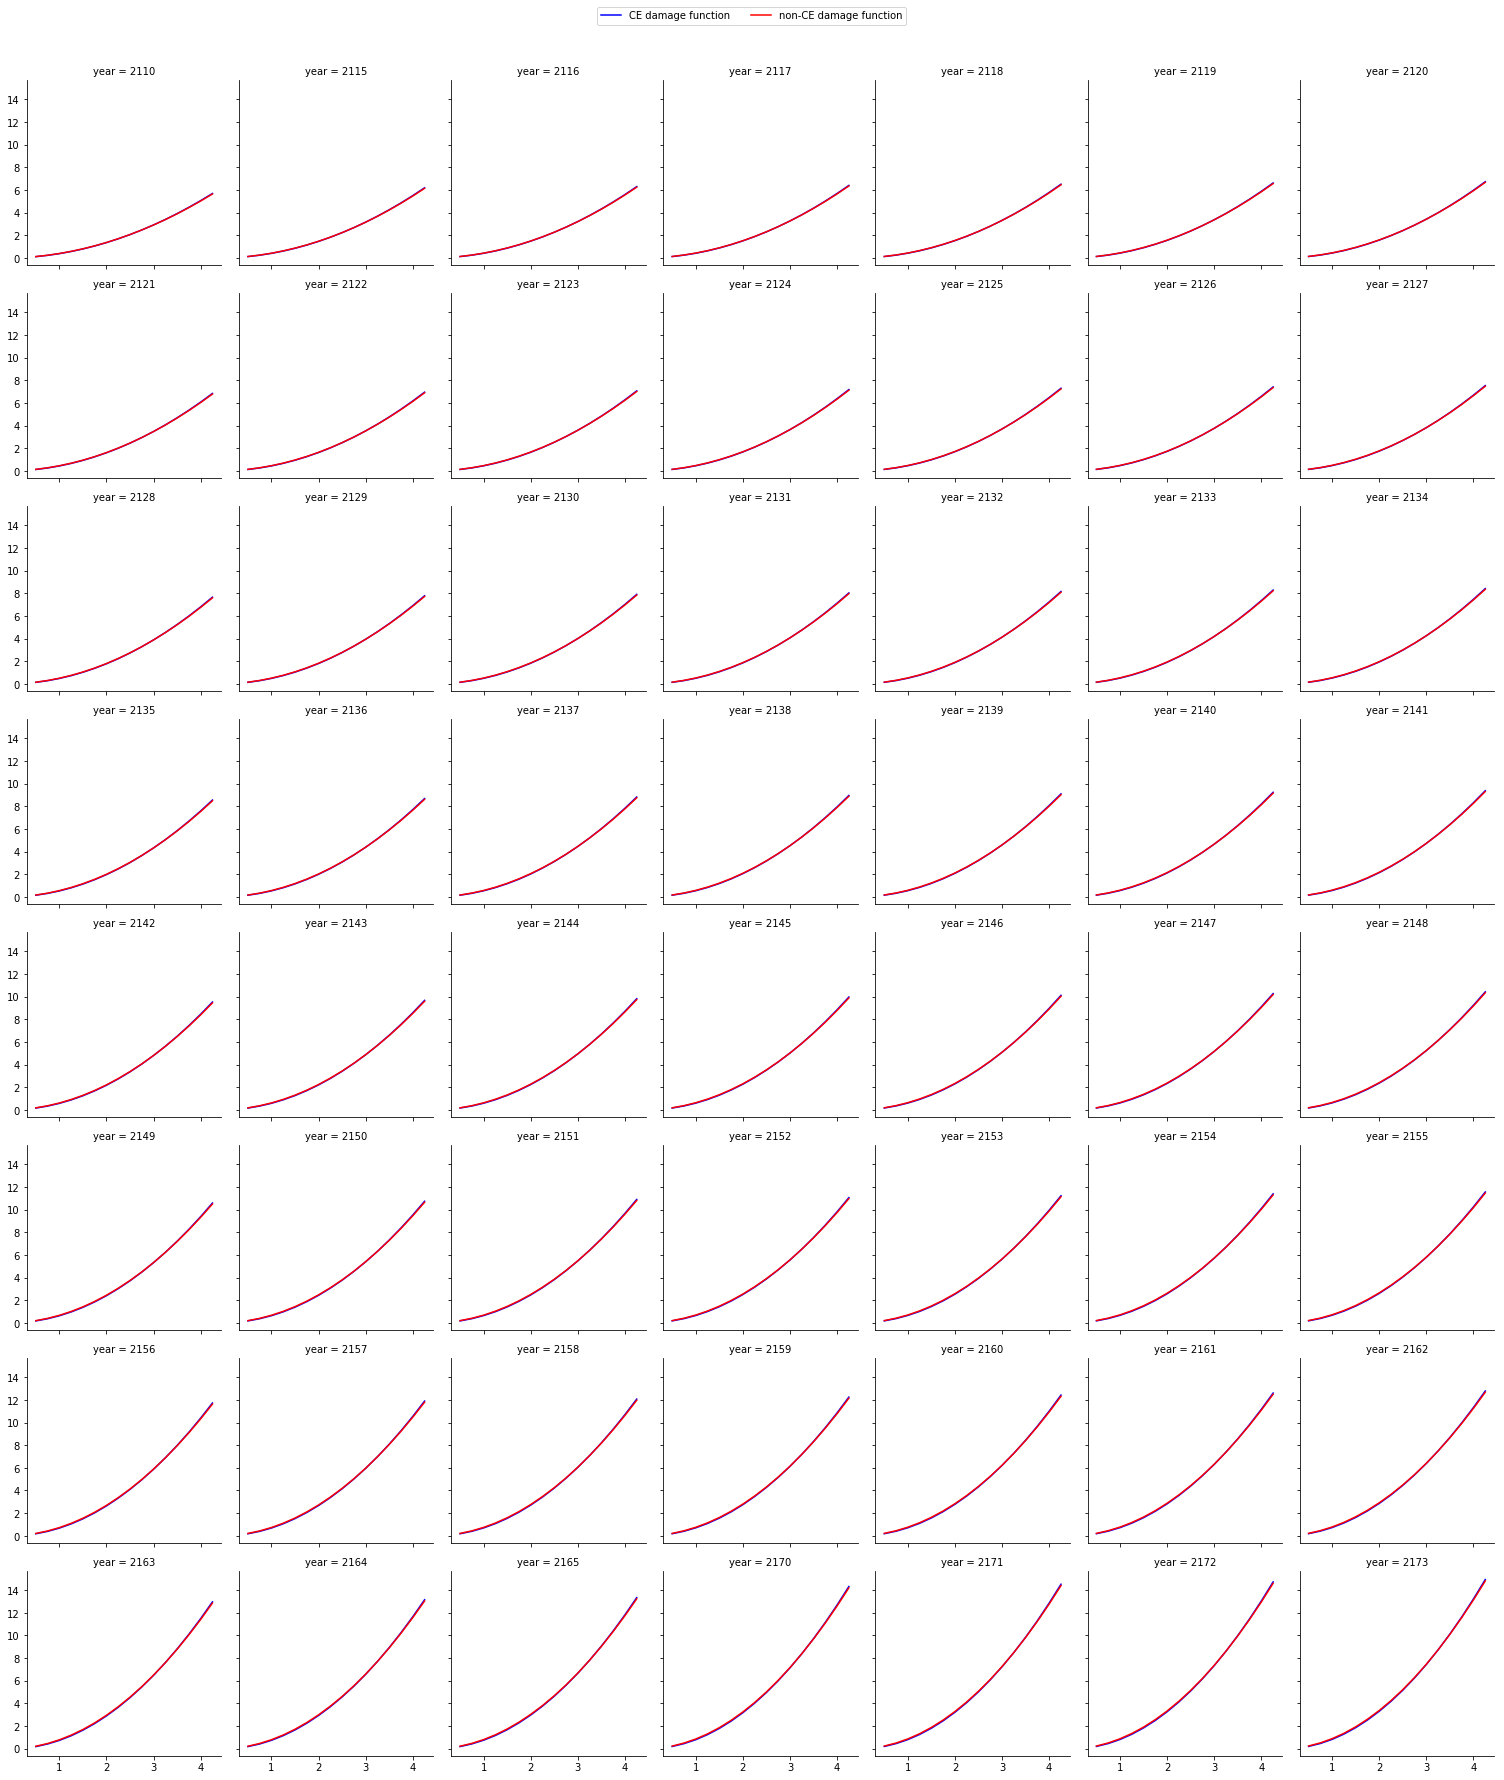

In [14]:
# grid plot of non-CE vs CE in years where discounted ce damages < non-ce damages under RCP4.5 
g = sns.FacetGrid(df1, col="year", col_wrap=7, sharey=True)
g.map_dataframe(sns.lineplot, x='temp', y='ce_df_T', color = "blue", label="CE damage function").map_dataframe(sns.lineplot, x='temp', y='mc_df_T', color = "red", label="non-CE damage function")
lgd = plt.legend(bbox_to_anchor=(-2,9.5), ncol=2)
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/damage_func_comparison.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

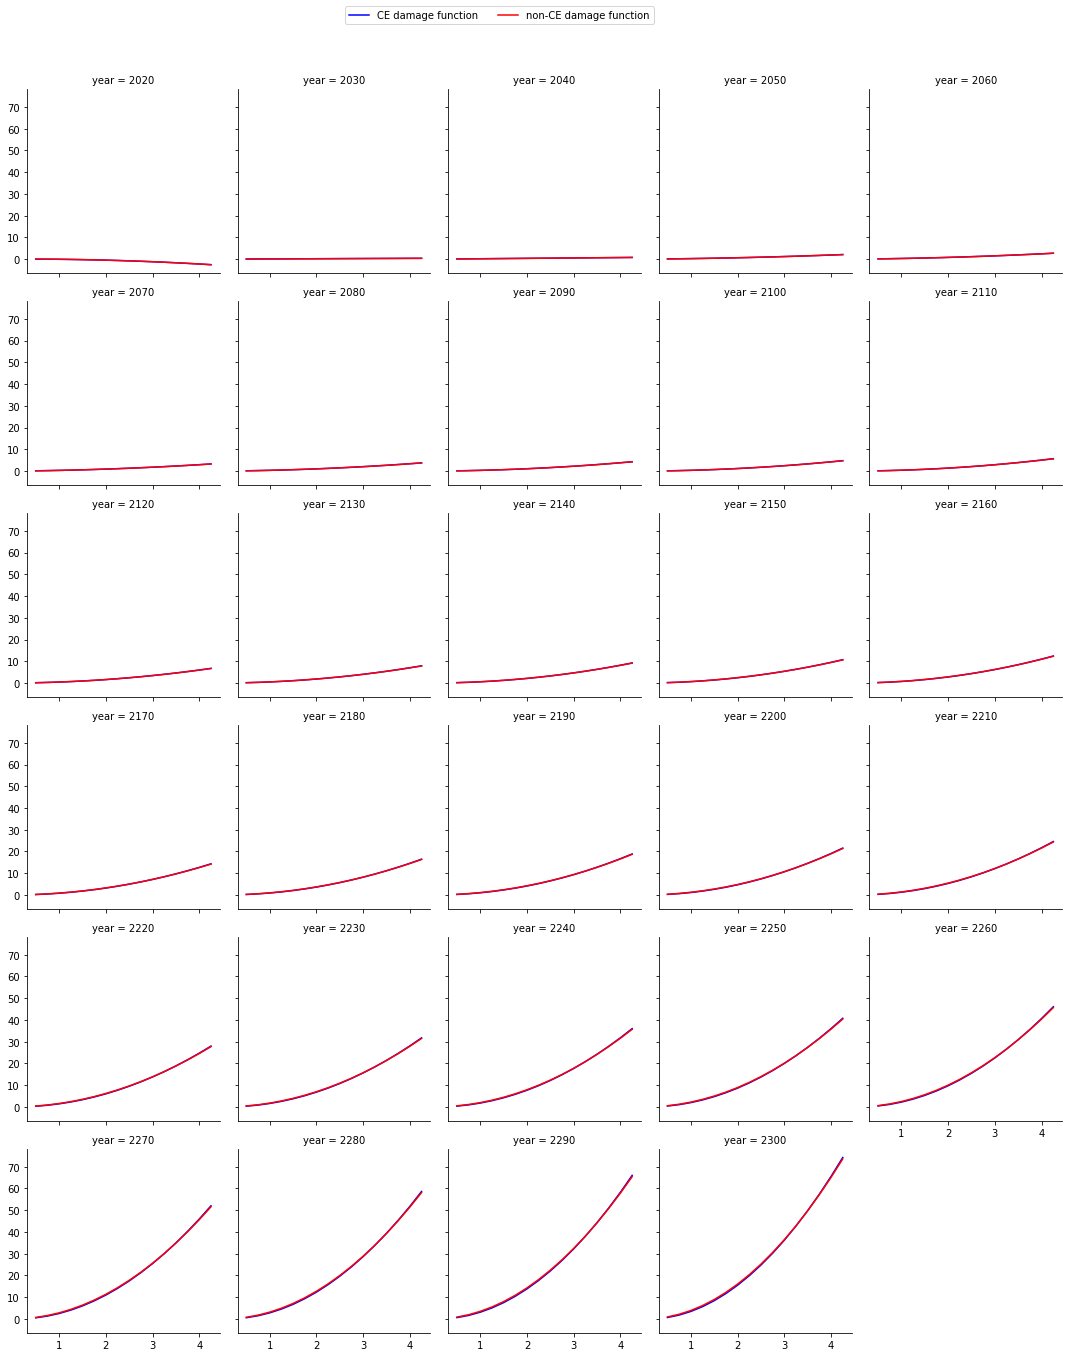

In [15]:
# making the grid plot of non-CE cloud smooth vs non-smooth anomalies
g = sns.FacetGrid(df2, col="year", col_wrap=5, sharey=True)
g.map_dataframe(sns.lineplot, x='temp', y='ce_df_T', color = "blue", label="CE damage function").map_dataframe(sns.lineplot, x='temp', y='mc_df_T', color = "red", label="non-CE damage function")
lgd = plt.legend(bbox_to_anchor=(0,7.25), ncol=2)
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/damage_all_years.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

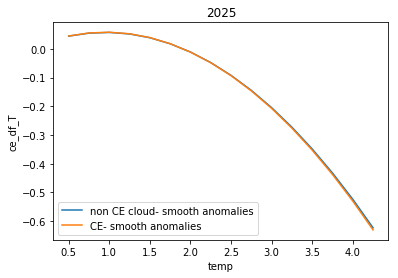

In [16]:
# trying the plot before the grid plot of DFs with smooth anomalies
sns.lineplot(data=mc_df.loc[mc_df.year == 2025], x='temp', y='mc_df_T', label="non CE cloud- smooth anomalies").set_title(2025)
sns.lineplot(data=ce_df.loc[ce_df.year == 2025], x='temp', y='ce_df_T', label="CE- smooth anomalies")
plt.legend()
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/ce/damage_function_comparison/CE_vs_non_CE_smooth_anomalies_2025.pdf', format='pdf')